Unified CNN Approach for Multi-Class MRI Brain Tumor Classification

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install colorama

Packages

In [4]:
import os
import random
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam


In [5]:
import warnings
warnings.filterwarnings("ignore")

let's see information about data

In [6]:
print('Training:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Training/glioma'))
print(f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Training/meningioma'))
print(f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Training/notumor'))
print(f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Training/pituitary'))
print(f'pituitary: {len(files)}\n')

print('Testing:\n')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Testing/glioma'))
print(f'glioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Testing/meningioma'))
print(f'meningioma: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Testing/notumor'))
print(f'notumor: {len(files)}')
path, dirs, files = next(os.walk('/content/drive/MyDrive/Dataset/Brain Tumar/Testing/pituitary'))
print(f'pituitary: {len(files)}\n')

Training:

glioma: 618
meningioma: 1339
notumor: 1595
pituitary: 1457

Testing:

glioma: 300
meningioma: 306
notumor: 405
pituitary: 300



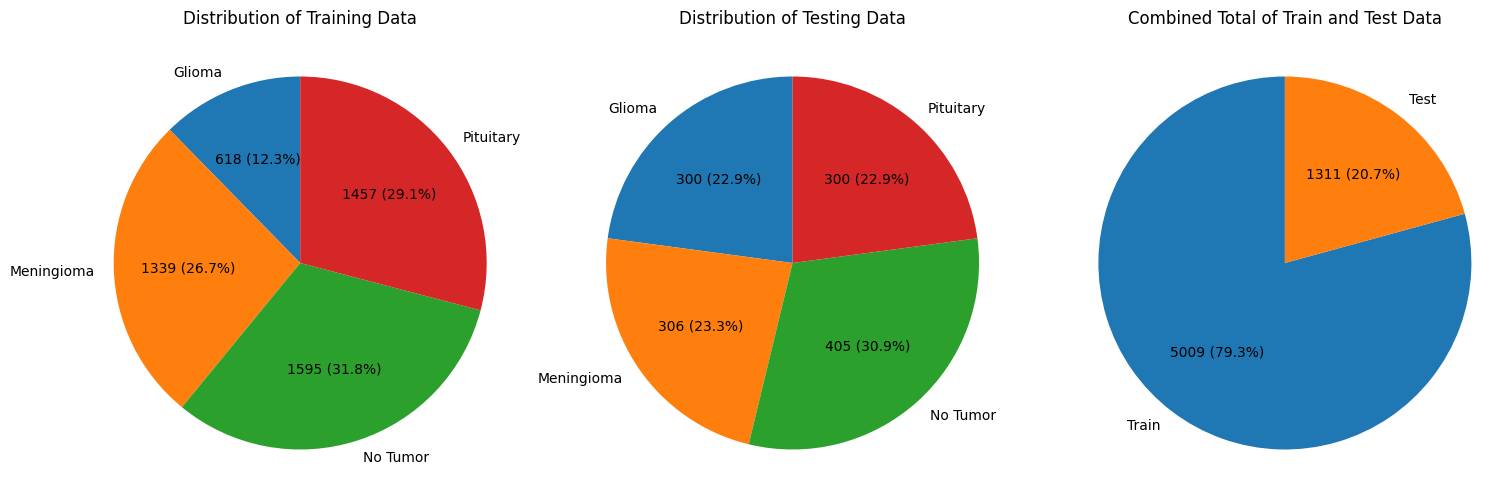

In [7]:
# Data for training and testing
train_counts = [618, 1339, 1595, 1457]
test_counts = [300, 306, 405, 300]
labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

total_train = sum(train_counts)
total_test = sum(test_counts)
total_labels = ['Train', 'Test']
total_counts = [total_train, total_test]

# Custom function for autopct to ensure accurate numbers
def custom_autopct(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{absolute} ({pct:.1f}%)"

def plot_pie_chart(data, labels, title, ax):
    ax.pie(data, labels=labels, autopct=lambda pct: custom_autopct(pct, data), startangle=90)
    ax.axis('equal')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_pie_chart(train_counts, labels, "Distribution of Training Data", axs[0])
plot_pie_chart(test_counts, labels, "Distribution of Testing Data", axs[1])
plot_pie_chart(total_counts, total_labels, "Combined Total of Train and Test Data", axs[2])

plt.show()

Here we create the Dataset and make preprocessing on it and Split it into Training, Validation and Testing Sets:

In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
train_dataset = image_dataset_from_directory('/content/drive/MyDrive/Dataset/Brain Tumar/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='training',
                                             label_mode = 'categorical',
                                             seed=42)

validation_dataset = image_dataset_from_directory('/content/drive/MyDrive/Dataset/Brain Tumar/Training',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.15,
                                             subset='validation',
                                             label_mode = 'categorical',
                                             seed=42)

test_dataset = image_dataset_from_directory('/content/drive/MyDrive/Dataset/Brain Tumar/Testing',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             label_mode = 'categorical',
                                            )
# prefetch the train_dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5009 files belonging to 4 classes.
Using 4258 files for training.
Found 5009 files belonging to 4 classes.
Using 751 files for validation.
Found 1311 files belonging to 4 classes.


In [9]:
# this cell to enable me to evaluate the model in confusion matrix
y_true = np.concatenate([ y for _ , y in test_dataset] , axis = 0)

let's see the images of our data

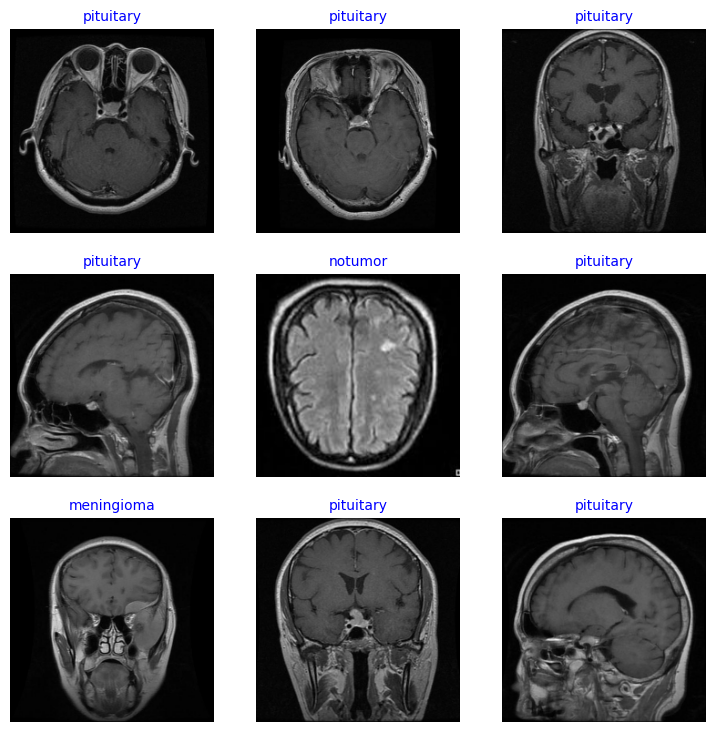

In [10]:
class_names = test_dataset.class_names
plt.figure(figsize=(9, 9))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])] , c = 'blue' , size = 10)
    plt.axis("off")

shuffle is done

# Models

In [11]:
# callbacks for the models
def get_callbacks (model_name):
  callbacks = []
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath= f'model.{model_name}.h5', monitor = 'val_loss', verbose = 1 ,
                                                    mode = 'min', save_best_only=True, save_freq='epoch')
  callbacks.append(checkpoint)
  rlr = tf.keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=0.0)
  callbacks.append(rlr)
  earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7)
  callbacks.append(earlystop)

  return callbacks

In [12]:
# function for plot resultes

def plot():
   pd.DataFrame(history.history)[['categorical_accuracy','val_categorical_accuracy','loss','val_loss']].plot( figsize=(7, 5), xlim=[0, 9], ylim=[0, 1], grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
   plt.show()

# for make dataframe for all model
model_name= ['My_model','DenseNet121','VGG16','ResNet50V2','MobileNetV2','EfficientNetV2S','Xception']
CategoricalAccuracy= []
losses= []

My_model

In [13]:
model = Sequential([
    tfl.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(64, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(128, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Conv2D(256, (3,3), activation='relu'),
    tfl.MaxPooling2D(2,2),
    tfl.Flatten(),
    tfl.Dense(512, activation='relu'),
    tfl.Dropout(0.5),
    tfl.Dense(4, activation='softmax')
])

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])



In [14]:
# fitting
callbacks = get_callbacks('my_model')
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - categorical_accuracy: 0.5994 - loss: 21.4186
Epoch 1: val_loss improved from inf to 0.59379, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - categorical_accuracy: 0.6002 - loss: 21.3018 - val_categorical_accuracy: 0.7843 - val_loss: 0.5938 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_accuracy: 0.8440 - loss: 0.4570
Epoch 2: val_loss improved from 0.59379 to 0.35789, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 173ms/step - categorical_accuracy: 0.8442 - loss: 0.4566 - val_categorical_accuracy: 0.8895 - val_loss: 0.3579 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_accuracy: 0.8938 - loss: 0.3228
Epoch 3: val_loss did not improve from 0.35789
134/134 ━━━━━━━━━━━━━━━━━━━━ 38s 153ms/step - categorical_accuracy: 0.8939 - loss: 0.3229 - val_categorical_accuracy: 0.8748 - val_loss: 0.3616 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.8873 - loss: 0.3394
Epoch 4: val_loss improved from 0.35789 to 0.33061, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - categorical_accuracy: 0.8876 - loss: 0.3386 - val_categorical_accuracy: 0.9015 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - categorical_accuracy: 0.9135 - loss: 0.2437
Epoch 5: val_loss improved from 0.33061 to 0.22149, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - categorical_accuracy: 0.9137 - loss: 0.2433 - val_categorical_accuracy: 0.9308 - val_loss: 0.2215 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_accuracy: 0.9433 - loss: 0.1722
Epoch 6: val_loss did not improve from 0.22149
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 143ms/step - categorical_accuracy: 0.9434 - loss: 0.1722 - val_categorical_accuracy: 0.9188 - val_loss: 0.2435 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - categorical_accuracy: 0.9541 - loss: 0.1487
Epoch 7: val_loss did not improve from 0.22149
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 140ms/step - categorical_accuracy: 0.9541 - loss: 0.1484 - val_categorical_accuracy: 0.9228 - val_loss: 0.2534 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_accuracy: 0.9698 - loss: 0.1059
Epoch 8: val_loss did not improve from 0.22149
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - categoric

134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - categorical_accuracy: 0.9764 - loss: 0.0745 - val_categorical_accuracy: 0.9547 - val_loss: 0.2146 - learning_rate: 0.0010


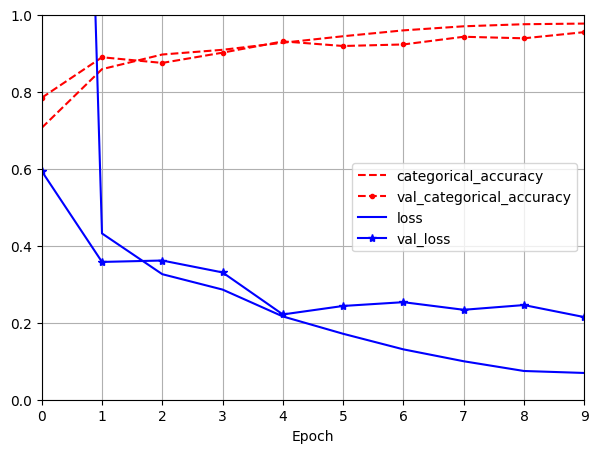

In [15]:
plot()

In [16]:
loss, categorical_accuracy = model.evaluate(test_dataset)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - categorical_accuracy: 0.7856 - loss: 1.3592


#DenseNet

In [17]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.densenet import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_densenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_densenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_densenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)

from tensorflow.keras.applications import DenseNet121


IMG_SHAPE = IMG_SIZE + (3,)

dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
dense_model.trainable = False

x = dense_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=dense_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy() , keras.metrics.Recall()])

In [18]:
# Now you can train the model
history = model.fit(
    train_dataset_densenet,
    epochs=10,
    validation_data=validation_dataset_densenet,
    callbacks=callbacks
)


Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - categorical_accuracy: 0.7463 - loss: 0.6966 - recall: 0.6995
Epoch 1: val_loss did not improve from 0.21463
134/134 ━━━━━━━━━━━━━━━━━━━━ 111s 596ms/step - categorical_accuracy: 0.7470 - loss: 0.6947 - recall: 0.7004 - val_categorical_accuracy: 0.8842 - val_loss: 0.3506 - val_recall: 0.8735 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - categorical_accuracy: 0.9056 - loss: 0.2567 - recall: 0.8964
Epoch 2: val_loss did not improve from 0.21463
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 193ms/step - categorical_accuracy: 0.9058 - loss: 0.2562 - recall: 0.8966 - val_categorical_accuracy: 0.9268 - val_loss: 0.2229 - val_recall: 0.9228 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - categorical_accuracy: 0.9246 - loss: 0.2056 - recall: 0.9202
Epoch 3: val_loss improved from 0.21463 to 0.18443, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - categorical_accuracy: 0.9247 - loss: 0.2053 - recall: 0.9203 - val_categorical_accuracy: 0.9374 - val_loss: 0.1844 - val_recall: 0.9294 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - categorical_accuracy: 0.9301 - loss: 0.1914 - recall: 0.9208
Epoch 4: val_loss improved from 0.18443 to 0.18143, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - categorical_accuracy: 0.9303 - loss: 0.1909 - recall: 0.9211 - val_categorical_accuracy: 0.9441 - val_loss: 0.1814 - val_recall: 0.9374 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - categorical_accuracy: 0.9277 - loss: 0.1971 - recall: 0.9195
Epoch 5: val_loss did not improve from 0.18143
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 200ms/step - categorical_accuracy: 0.9280 - loss: 0.1965 - recall: 0.9198 - val_categorical_accuracy: 0.9361 - val_loss: 0.1853 - val_recall: 0.9308 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - categorical_accuracy: 0.9601 - loss: 0.1245 - recall: 0.9559
Epoch 6: val_loss improved from 0.18143 to 0.16538, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 27s 201ms/step - categorical_accuracy: 0.9601 - loss: 0.1244 - recall: 0.9559 - val_categorical_accuracy: 0.9361 - val_loss: 0.1654 - val_recall: 0.9334 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - categorical_accuracy: 0.9688 - loss: 0.0975 - recall: 0.9676
Epoch 7: val_loss did not improve from 0.16538
134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - categorical_accuracy: 0.9688 - loss: 0.0975 - recall: 0.9676 - val_categorical_accuracy: 0.9308 - val_loss: 0.1928 - val_recall: 0.9268 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - categorical_accuracy: 0.9639 - loss: 0.0968 - recall: 0.9635
Epoch 8: val_loss did not improve from 0.16538
134/134 ━━━━━━━━━━━━━━━━━━━━ 26s 192ms/step - categorical_accuracy: 0.9640 - loss: 0.0967 - recall: 0.9635 - val_categorical_accuracy: 0.9254 - val_loss: 0.2082 - val_recall: 0.9228 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step 

134/134 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - categorical_accuracy: 0.9518 - loss: 0.1271 - recall: 0.9509 - val_categorical_accuracy: 0.9494 - val_loss: 0.1296 - val_recall: 0.9467 - learning_rate: 0.0010
Epoch 10/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - categorical_accuracy: 0.9829 - loss: 0.0568 - recall: 0.9822
Epoch 10: val_loss improved from 0.12963 to 0.12728, saving model to model.my_model.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 190ms/step - categorical_accuracy: 0.9829 - loss: 0.0567 - recall: 0.9822 - val_categorical_accuracy: 0.9587 - val_loss: 0.1273 - val_recall: 0.9574 - learning_rate: 0.0010


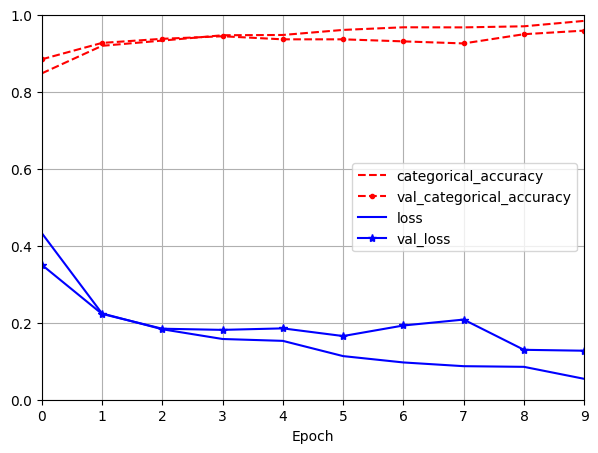

In [19]:
plot()

In [20]:
loss, categorical_accuracy, recall = model.evaluate(test_dataset_densenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 451ms/step - categorical_accuracy: 0.8535 - loss: 0.5799 - recall: 0.8503


#VGG-16

In [21]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.vgg16 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_vgg16 = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_vgg16 = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_vgg16 = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import VGG16

IMG_SHAPE = IMG_SIZE + (3,)

VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
VGG16_model.trainable = False

x = VGG16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=VGG16_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])



In [22]:
# fitting
callbacks = get_callbacks('VGG16')
history = model.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - categorical_accuracy: 0.7467 - loss: 0.9568
Epoch 1: val_loss improved from inf to 0.40003, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 52s 285ms/step - categorical_accuracy: 0.7475 - loss: 0.9535 - val_categorical_accuracy: 0.8615 - val_loss: 0.4000 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - categorical_accuracy: 0.9309 - loss: 0.2113
Epoch 2: val_loss improved from 0.40003 to 0.20824, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 207ms/step - categorical_accuracy: 0.9310 - loss: 0.2109 - val_categorical_accuracy: 0.9294 - val_loss: 0.2082 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - categorical_accuracy: 0.9576 - loss: 0.1173
Epoch 3: val_loss improved from 0.20824 to 0.17433, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 29s 213ms/step - categorical_accuracy: 0.9576 - loss: 0.1172 - val_categorical_accuracy: 0.9414 - val_loss: 0.1743 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - categorical_accuracy: 0.9678 - loss: 0.0931
Epoch 4: val_loss improved from 0.17433 to 0.16055, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - categorical_accuracy: 0.9678 - loss: 0.0931 - val_categorical_accuracy: 0.9507 - val_loss: 0.1606 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - categorical_accuracy: 0.9818 - loss: 0.0575
Epoch 5: val_loss did not improve from 0.16055
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - categorical_accuracy: 0.9818 - loss: 0.0574 - val_categorical_accuracy: 0.9521 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - categorical_accuracy: 0.9886 - loss: 0.0399
Epoch 6: val_loss improved from 0.16055 to 0.13672, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 210ms/step - categorical_accuracy: 0.9886 - loss: 0.0399 - val_categorical_accuracy: 0.9587 - val_loss: 0.1367 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - categorical_accuracy: 0.9870 - loss: 0.0381
Epoch 7: val_loss improved from 0.13672 to 0.13623, saving model to model.VGG16.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step - categorical_accuracy: 0.9870 - loss: 0.0380 - val_categorical_accuracy: 0.9614 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - categorical_accuracy: 0.9914 - loss: 0.0287
Epoch 8: val_loss did not improve from 0.13623
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 210ms/step - categorical_accuracy: 0.9915 - loss: 0.0286 - val_categorical_accuracy: 0.9494 - val_loss: 0.1608 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - categorical_accuracy: 0.9959 - loss: 0.0188
Epoch 9: val_loss did not improve from 0.13623
134/134 ━━━━━━━━━━━━━━━━━━━━ 29s 215ms/step - categorical_accuracy: 0.9959 - loss: 0.0187 - val_categorical_accuracy: 0.9547 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 10/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - categorical_accuracy: 0.9968 - loss: 0.0104
Epoch 10: val_loss did not improve from 0.13623
134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 206ms/step - categor

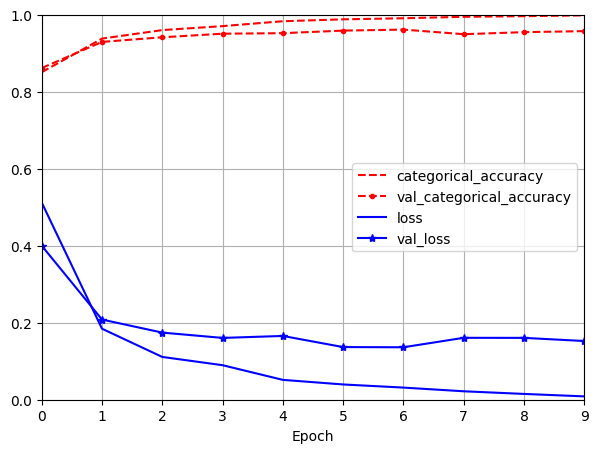

In [23]:
plot()


In [24]:
loss, categorical_accuracy = model.evaluate(test_dataset_vgg16)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 433ms/step - categorical_accuracy: 0.8355 - loss: 0.7915


#ResNet50V2

In [25]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.resnet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_resnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_resnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_resnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import ResNet50V2
IMG_SHAPE = IMG_SIZE + (3,)

ResNet_model = ResNet50V2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
ResNet_model.trainable = False

x = ResNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=ResNet_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])



In [26]:
# fitting
callbacks = get_callbacks('ResNet50V2')
history = model.fit(
    train_dataset_resnet,
    epochs=10,
    validation_data=validation_dataset_resnet,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - categorical_accuracy: 0.7789 - loss: 0.6217
Epoch 1: val_loss improved from inf to 0.21206, saving model to model.ResNet50V2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 45s 232ms/step - categorical_accuracy: 0.7795 - loss: 0.6200 - val_categorical_accuracy: 0.9241 - val_loss: 0.2121 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_accuracy: 0.9391 - loss: 0.1844
Epoch 2: val_loss improved from 0.21206 to 0.20235, saving model to model.ResNet50V2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 135ms/step - categorical_accuracy: 0.9392 - loss: 0.1842 - val_categorical_accuracy: 0.9441 - val_loss: 0.2024 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - categorical_accuracy: 0.9644 - loss: 0.1071
Epoch 3: val_loss improved from 0.20235 to 0.14855, saving model to model.ResNet50V2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - categorical_accuracy: 0.9645 - loss: 0.1069 - val_categorical_accuracy: 0.9547 - val_loss: 0.1485 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - categorical_accuracy: 0.9795 - loss: 0.0677
Epoch 4: val_loss did not improve from 0.14855
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - categorical_accuracy: 0.9795 - loss: 0.0675 - val_categorical_accuracy: 0.9401 - val_loss: 0.1883 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_accuracy: 0.9892 - loss: 0.0425
Epoch 5: val_loss did not improve from 0.14855
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - categorical_accuracy: 0.9892 - loss: 0.0425 - val_categorical_accuracy: 0.9494 - val_loss: 0.1567 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_accuracy: 0.9866 - loss: 0.0394
Epoch 6: val_loss improved from 0.14855 to 0.14552, saving model to model.ResNet50V2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - categorical_accuracy: 0.9866 - loss: 0.0393 - val_categorical_accuracy: 0.9547 - val_loss: 0.1455 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_accuracy: 0.9971 - loss: 0.0148
Epoch 7: val_loss did not improve from 0.14552
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - categorical_accuracy: 0.9971 - loss: 0.0148 - val_categorical_accuracy: 0.9441 - val_loss: 0.2002 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - categorical_accuracy: 0.9980 - loss: 0.0127
Epoch 8: val_loss did not improve from 0.14552
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - categorical_accuracy: 0.9980 - loss: 0.0127 - val_categorical_accuracy: 0.9561 - val_loss: 0.1547 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.9978 - loss: 0.0097
Epoch 9: val_loss did not improve from 0.14552
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - categoric

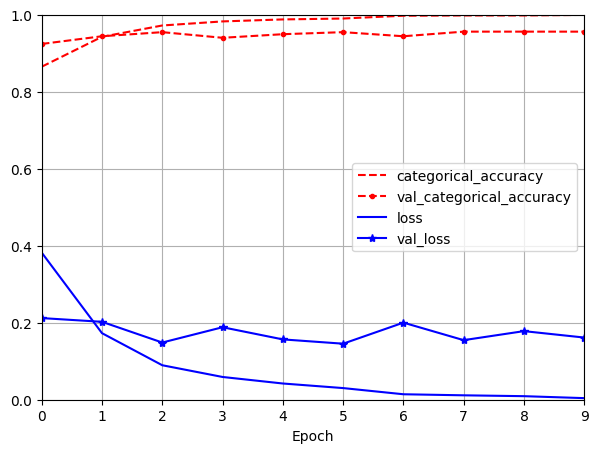

In [27]:
plot()

In [28]:
loss, categorical_accuracy = model.evaluate(test_dataset_resnet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - categorical_accuracy: 0.8485 - loss: 0.8383


#MobileNetV2

In [29]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_mobilenet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_mobilenet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_mobilenet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import MobileNetV2

IMG_SHAPE = IMG_SIZE + (3,)

MobileNet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
MobileNet_model.trainable = False

x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=MobileNet_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])


In [30]:

# fitting
callbacks = get_callbacks('MobileNetV2')
history = model.fit(
    train_dataset_mobilenet,
    epochs=10,
    validation_data=validation_dataset_mobilenet,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - categorical_accuracy: 0.8233 - loss: 0.4876
Epoch 1: val_loss improved from inf to 0.27238, saving model to model.MobileNetV2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 241ms/step - categorical_accuracy: 0.8238 - loss: 0.4865 - val_categorical_accuracy: 0.9041 - val_loss: 0.2724 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - categorical_accuracy: 0.9381 - loss: 0.1811
Epoch 2: val_loss did not improve from 0.27238
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - categorical_accuracy: 0.9382 - loss: 0.1808 - val_categorical_accuracy: 0.8216 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorical_accuracy: 0.9260 - loss: 0.2324
Epoch 3: val_loss improved from 0.27238 to 0.15419, saving model to model.MobileNetV2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - categorical_accuracy: 0.9263 - loss: 0.2311 - val_categorical_accuracy: 0.9507 - val_loss: 0.1542 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_accuracy: 0.9712 - loss: 0.0779
Epoch 4: val_loss improved from 0.15419 to 0.14414, saving model to model.MobileNetV2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - categorical_accuracy: 0.9713 - loss: 0.0779 - val_categorical_accuracy: 0.9561 - val_loss: 0.1441 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - categorical_accuracy: 0.9834 - loss: 0.0568
Epoch 5: val_loss improved from 0.14414 to 0.12743, saving model to model.MobileNetV2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 131ms/step - categorical_accuracy: 0.9834 - loss: 0.0568 - val_categorical_accuracy: 0.9587 - val_loss: 0.1274 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - categorical_accuracy: 0.9818 - loss: 0.0508
Epoch 6: val_loss did not improve from 0.12743
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - categorical_accuracy: 0.9819 - loss: 0.0506 - val_categorical_accuracy: 0.9547 - val_loss: 0.1342 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - categorical_accuracy: 0.9939 - loss: 0.0285
Epoch 7: val_loss improved from 0.12743 to 0.12737, saving model to model.MobileNetV2.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 162ms/step - categorical_accuracy: 0.9939 - loss: 0.0284 - val_categorical_accuracy: 0.9627 - val_loss: 0.1274 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - categorical_accuracy: 0.9970 - loss: 0.0172
Epoch 8: val_loss did not improve from 0.12737
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 134ms/step - categorical_accuracy: 0.9970 - loss: 0.0171 - val_categorical_accuracy: 0.9627 - val_loss: 0.1424 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - categorical_accuracy: 0.9975 - loss: 0.0115
Epoch 9: val_loss did not improve from 0.12737
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 155ms/step - categorical_accuracy: 0.9975 - loss: 0.0115 - val_categorical_accuracy: 0.9561 - val_loss: 0.1540 - learning_rate: 0.0010
Epoch 10/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - categorical_accuracy: 0.9987 - loss: 0.0110
Epoch 10: val_loss did not improve from 0.12737
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - categor

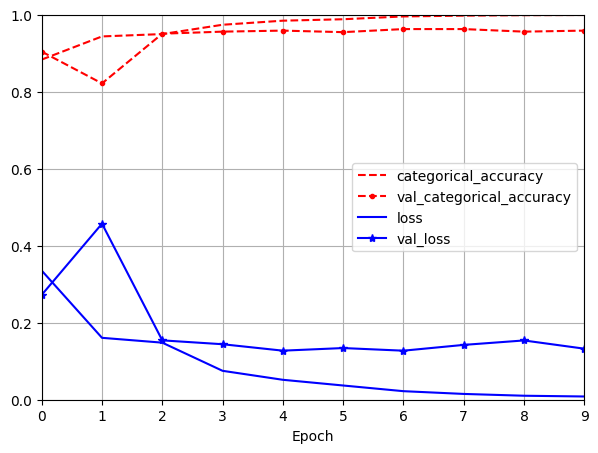

In [31]:
plot()


In [32]:
loss, categorical_accuracy = model.evaluate(test_dataset_mobilenet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - categorical_accuracy: 0.8510 - loss: 0.7680


#EfficientNetV2S

In [33]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_efficientnet = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_efficientnet = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_efficientnet = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import EfficientNetV2S
IMG_SHAPE = IMG_SIZE + (3,)

EfficientNet_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
EfficientNet_model.trainable = False

x = EfficientNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=EfficientNet_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])



In [34]:
# fitting
callbacks = get_callbacks('EfficientNetV2S')
history = model.fit(
    train_dataset_efficientnet,
    epochs=10,
    validation_data=validation_dataset_efficientnet,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - categorical_accuracy: 0.8007 - loss: 0.5244
Epoch 1: val_loss improved from inf to 0.30977, saving model to model.EfficientNetV2S.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 112s 475ms/step - categorical_accuracy: 0.8012 - loss: 0.5234 - val_categorical_accuracy: 0.9041 - val_loss: 0.3098 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - categorical_accuracy: 0.9087 - loss: 0.2520
Epoch 2: val_loss improved from 0.30977 to 0.21232, saving model to model.EfficientNetV2S.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - categorical_accuracy: 0.9088 - loss: 0.2518 - val_categorical_accuracy: 0.9268 - val_loss: 0.2123 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.9330 - loss: 0.1906
Epoch 3: val_loss improved from 0.21232 to 0.20497, saving model to model.EfficientNetV2S.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 172ms/step - categorical_accuracy: 0.9330 - loss: 0.1905 - val_categorical_accuracy: 0.9308 - val_loss: 0.2050 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.9526 - loss: 0.1352
Epoch 4: val_loss improved from 0.20497 to 0.14298, saving model to model.EfficientNetV2S.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 170ms/step - categorical_accuracy: 0.9525 - loss: 0.1353 - val_categorical_accuracy: 0.9561 - val_loss: 0.1430 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.9561 - loss: 0.1312
Epoch 5: val_loss did not improve from 0.14298
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - categorical_accuracy: 0.9560 - loss: 0.1313 - val_categorical_accuracy: 0.9574 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - categorical_accuracy: 0.9649 - loss: 0.1062
Epoch 6: val_loss did not improve from 0.14298
134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 160ms/step - categorical_accuracy: 0.9649 - loss: 0.1062 - val_categorical_accuracy: 0.9401 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - categorical_accuracy: 0.9608 - loss: 0.1036
Epoch 7: val_loss did not improve from 0.14298
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 157ms/step - categoric

134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - categorical_accuracy: 0.9627 - loss: 0.1038 - val_categorical_accuracy: 0.9601 - val_loss: 0.1287 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_accuracy: 0.9724 - loss: 0.0779
Epoch 9: val_loss did not improve from 0.12871
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - categorical_accuracy: 0.9724 - loss: 0.0778 - val_categorical_accuracy: 0.9534 - val_loss: 0.1470 - learning_rate: 0.0010
Epoch 10/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - categorical_accuracy: 0.9719 - loss: 0.0728
Epoch 10: val_loss did not improve from 0.12871
134/134 ━━━━━━━━━━━━━━━━━━━━ 18s 137ms/step - categorical_accuracy: 0.9719 - loss: 0.0728 - val_categorical_accuracy: 0.9561 - val_loss: 0.1384 - learning_rate: 0.0010


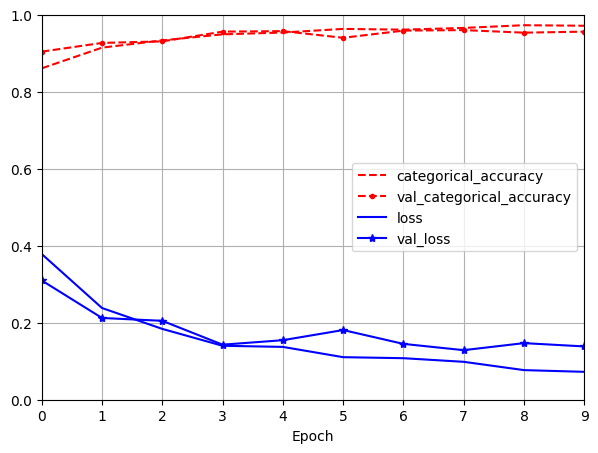

In [35]:
plot()


In [36]:
loss, categorical_accuracy = model.evaluate(test_dataset_efficientnet)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - categorical_accuracy: 0.8058 - loss: 0.7154


#Xception

In [37]:
# Apply preprocessing to datasets

from tensorflow.keras.applications.xception import preprocess_input

def preprocess_data(image, label):
    return preprocess_input(image), label

train_dataset_xception = train_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
validation_dataset_xception = validation_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_dataset_xception = test_dataset.map(preprocess_data, num_parallel_calls=AUTOTUNE)


from tensorflow.keras.applications import Xception

IMG_SHAPE = IMG_SIZE + (3,)

Xception_model = Xception(weights='imagenet', include_top=False, input_shape= IMG_SHAPE , classes = 4)
Xception_model.trainable = False

x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=Xception_model.input, outputs=predictions)

OPTIMIZER = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
LOSS = keras.losses.CategoricalCrossentropy()
model.compile(optimizer= OPTIMIZER, loss= LOSS, metrics=[keras.metrics.CategoricalAccuracy()])



In [38]:
# fitting
callbacks = get_callbacks('Xception')
history = model.fit(
    train_dataset_xception,
    epochs=10,
    validation_data=validation_dataset_xception,
    callbacks=callbacks
)

Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - categorical_accuracy: 0.7893 - loss: 0.5478
Epoch 1: val_loss improved from inf to 0.28132, saving model to model.Xception.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 46s 239ms/step - categorical_accuracy: 0.7897 - loss: 0.5467 - val_categorical_accuracy: 0.8975 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 2/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - categorical_accuracy: 0.9192 - loss: 0.2324
Epoch 2: val_loss improved from 0.28132 to 0.23491, saving model to model.Xception.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 167ms/step - categorical_accuracy: 0.9193 - loss: 0.2322 - val_categorical_accuracy: 0.9214 - val_loss: 0.2349 - learning_rate: 0.0010
Epoch 3/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_accuracy: 0.9420 - loss: 0.1645
Epoch 3: val_loss did not improve from 0.23491
134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 157ms/step - categorical_accuracy: 0.9420 - loss: 0.1644 - val_categorical_accuracy: 0.8908 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 4/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - categorical_accuracy: 0.9453 - loss: 0.1506
Epoch 4: val_loss improved from 0.23491 to 0.20723, saving model to model.Xception.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - categorical_accuracy: 0.9454 - loss: 0.1503 - val_categorical_accuracy: 0.9214 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 5/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - categorical_accuracy: 0.9738 - loss: 0.0894
Epoch 5: val_loss improved from 0.20723 to 0.15351, saving model to model.Xception.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 171ms/step - categorical_accuracy: 0.9737 - loss: 0.0895 - val_categorical_accuracy: 0.9427 - val_loss: 0.1535 - learning_rate: 0.0010
Epoch 6/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - categorical_accuracy: 0.9763 - loss: 0.0664
Epoch 6: val_loss did not improve from 0.15351
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - categorical_accuracy: 0.9763 - loss: 0.0664 - val_categorical_accuracy: 0.9414 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 7/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - categorical_accuracy: 0.9846 - loss: 0.0651
Epoch 7: val_loss did not improve from 0.15351
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 152ms/step - categorical_accuracy: 0.9846 - loss: 0.0649 - val_categorical_accuracy: 0.9427 - val_loss: 0.1790 - learning_rate: 0.0010
Epoch 8/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - categorical_accuracy: 0.9904 - loss: 0.0367
Epoch 8: val_loss improved from 0.15351 to 0.13781, saving model to model.Xception.h5


134/134 ━━━━━━━━━━━━━━━━━━━━ 22s 163ms/step - categorical_accuracy: 0.9904 - loss: 0.0368 - val_categorical_accuracy: 0.9534 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 9/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - categorical_accuracy: 0.9895 - loss: 0.0374
Epoch 9: val_loss did not improve from 0.13781
134/134 ━━━━━━━━━━━━━━━━━━━━ 23s 167ms/step - categorical_accuracy: 0.9895 - loss: 0.0374 - val_categorical_accuracy: 0.9454 - val_loss: 0.1586 - learning_rate: 0.0010
Epoch 10/10
133/134 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.9963 - loss: 0.0227
Epoch 10: val_loss did not improve from 0.13781
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - categorical_accuracy: 0.9963 - loss: 0.0227 - val_categorical_accuracy: 0.9294 - val_loss: 0.2067 - learning_rate: 0.0010


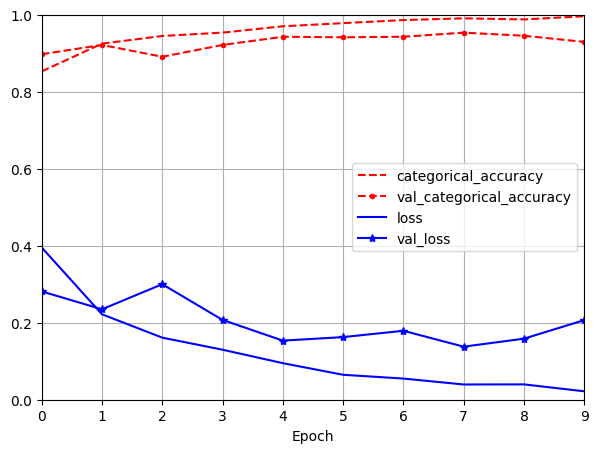

In [39]:
plot()


In [40]:
loss, categorical_accuracy = model.evaluate(test_dataset_xception)
CategoricalAccuracy.append(categorical_accuracy)
losses.append(loss)

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 306ms/step - categorical_accuracy: 0.8473 - loss: 0.5412


In [45]:
# here i  will make dataframe for all models_info

models_df = pd.DataFrame({"model-name":model_name, "Categorical_accuracy": CategoricalAccuracy , 'Loss': losses})
models_df = models_df.set_index('model-name')
models_df.sort_values("Loss", ascending = True)

,Categorical_accuracy,Loss
model-name,,
Xception,0.897788,0.343834
DenseNet121,0.912281,0.348224
EfficientNetV2S,0.895500,0.404072
MobileNetV2,0.912281,0.435528
VGG16,0.903127,0.455904
ResNet50V2,0.911518,0.466738
My_model,0.868040,0.800524


**The best model is "DenseNet121"**

Saving the model

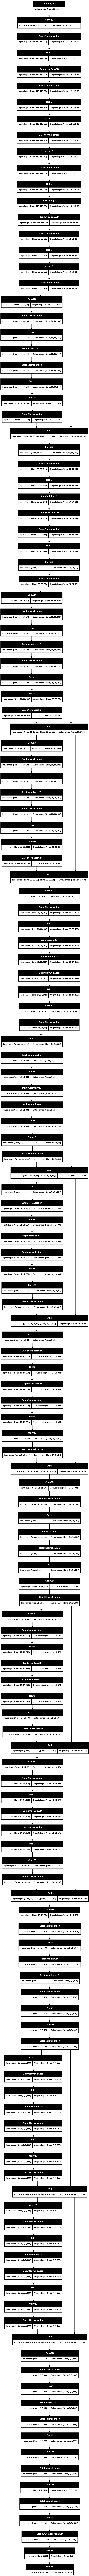

In [54]:
best_model = keras.models.load_model('model.MobileNetV2.h5')
tf.keras.utils.plot_model(best_model, show_shapes=True)

Fine-tuning

In [1]:
MobileNetV2_tuning = keras.models.load_model('/content/model.MobileNetV2.h5')

NameError: name 'keras' is not defined

In [ ]:
for layer in vgg_tuning.layers[:17]:
    layer.trainable = False
# Set the last 5 layers to trainable
for layer in vgg_tuning.layers[17:]:
    layer.trainable = True

callbacks = get_callbacks('vgg_tuning')
history = vgg_tuning.fit(
    train_dataset_vgg16,
    epochs=10,
    validation_data=validation_dataset_vgg16,
    callbacks=callbacks
)

In [ ]:
loss, categorical_accuracy = vgg_tuning.evaluate(test_dataset_vgg16)

In [ ]:
y_true = np.argmax(y_true, axis=1)
y_pred = vgg_tuning.predict(test_dataset_vgg16)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true , y_pred)
plt.title("Confusion Matrix", fontname = "monospace", fontsize = 15, weight = "bold")
plt.show()

In [87]:
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names = class_names, digits= 4))


Classification Report:



NameError: name 'classification_report' is not defined